In [1]:
import torch
from torchvision.models import inception_v3
from torchvision import transforms
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance

device = torch.device(f'cuda:3' if torch.cuda.is_available() else 'cpu')
fid = FrechetInceptionDistance(feature=64).to(device)

In [2]:
dir = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/mbt2018'
for name in os.listdir(dir):
    print(name)

celebA
fairface


In [10]:
generated_images_path = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/mbt2018/fairface/q_0001'
meta_data_path = '/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv'
clean_images_path = '/media/global_data/fair_neural_compression_data/datasets/RFW/data_64'

meta_data_inf = pd.read_csv(meta_data_path).to_numpy()

In [11]:
def get_images(meta_data_inf, path):
    image_tensors = []
    for meta_data in tqdm(meta_data_inf, total=len(meta_data_inf)):
        file_path = os.path.join(path, meta_data[2], meta_data[1])
        image = Image.open(file_path).convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        image_tensors.append(image_tensor)
    
    image_tensors = torch.stack(image_tensors, dim=0)
    return image_tensors

In [12]:
generated_image_tensors = get_images(meta_data_inf, generated_images_path)

100%|██████████| 40607/40607 [00:10<00:00, 3723.69it/s]


In [13]:
generated_image_tensors = generated_image_tensors.to(device).to(torch.uint8)

In [14]:
clean_image_tensors = get_images(meta_data_inf, clean_images_path)

100%|██████████| 40607/40607 [00:10<00:00, 3854.01it/s]


In [15]:
clean_image_tensors = clean_image_tensors.to(device).to(torch.uint8)

In [26]:
def update_fid_in_batches(fid, images, batch_size=128, real=True):
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        fid.update(batch, real=real)

In [ ]:
update_fid_in_batches(fid, clean_image_tensors, batch_size=64, real=True)
update_fid_in_batches(fid, generated_image_tensors, batch_size=64, real=False)


In [48]:
float(fid.compute())

1.4183015082380734e-05

- mbt2018
    - celebA
        - q0001: 6.5600e-05
        - q0009: 2.8195e-05
        - q1:
        - q2:
        - q3: 1.9363e-05
        
    - fairface
        - q0001: 9.0552e-05
        - q0009: 1.4183e-05
        - q1: 
        - q2:
        - q3:


In [4]:
model = inception_v3(pretrained=True, transform_input=False)
model.fc = torch.nn.Identity()  # Remove the final classification layer
model = model.eval()

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import json

bias_data_path = '/media/global_data/fair_neural_compression_data/fairness.json'
fid_data_path = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/fid.json'
with open(bias_data_path, 'r') as json_file:
    bias_data = json.load(json_file)
    
with open(fid_data_path, 'r') as json_file:
    fid_data = json.load(json_file)

In [6]:
bias_data.keys()

dict_keys(['hyperprior', 'qres17m', 'cheng2020-attn', 'mbt2018'])

In [7]:
data_path = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64'
bpp_data = {}
for model_name in fid_data:
    if model_name == 'jpeg':
        continue
    print(f'model_name: {model_name}')
    bpp_data[model_name] = {}
    model_path = f'{data_path}/{model_name}'
    for dataset in fid_data[model_name]:
        print(f'dataset: {dataset}')
        bpp_data[model_name][dataset] = {}
        dataset_path = f'{model_path}/{dataset}'
        for quality in fid_data[model_name][dataset]:
            stats_path = f'{dataset_path}/{quality}/stats.json'
            with open(stats_path, 'r') as json_file:
                stats_data = json.load(json_file)
            if "results" in stats_data:
                bpp_data[model_name][dataset][quality] = stats_data['results']['bpp']
            elif "est_bpp" in stats_data:
                bpp_data[model_name][dataset][quality] = stats_data['est_bpp']
bpp_data

model_name: qres17m_lmb_64
dataset: fairface
dataset: celebA
model_name: mbt2018
dataset: fairface
dataset: celebA
model_name: hyperprior
dataset: fairface
dataset: celebA
model_name: cheng2020-attn
dataset: fairface
dataset: celebA


{'qres17m_lmb_64': {'fairface': {'1': 0.00886532558800188,
   '3': 0.02282370359182936,
   '12': 0.7223974981481218,
   '9': 0.404614933002803,
   '6': 0.15795940315773765},
  'celebA': {'1': 0.010865931109864174,
   '3': 0.01401326913838128,
   '12': 0.6997467670037869,
   '9': 0.4595163508693375,
   '6': 0.20318071834509452}},
 'mbt2018': {'fairface': {'q_0001': 0.016809767051736497,
   'q_3': 0.5218644282039855,
   'q_0009': 0.1548888608237158,
   'q_1': 0.22898081410871188,
   'q_2': 0.3578851009571441},
  'celebA': {'q_0001': 0.020051372451441445,
   'q_3': 0.5174065784374351,
   'q_0009': 0.15650851445510033,
   'q_1': 0.2411556771732332,
   'q_2': 0.3580438339891074}},
 'hyperprior': {'fairface': {'q_0001': 0.02389208837651166,
   'q_3': 0.5033693308406143,
   'q_0009': 0.1269041086678334,
   'q_1': 0.21954348773464366,
   'q_2': 0.34495363053285133},
  'celebA': {'q_0001': 0.03605595400890076,
   'q_3': 0.5228528544601424,
   'q_0009': 0.14813256551099604,
   'q_1': 0.236050330

In [8]:
fid_data['qres17m'] = fid_data.pop('qres17m_lmb_64')

In [9]:
bpp_data['qres17m'] = bpp_data.pop('qres17m_lmb_64')

In [10]:
def is_integer_string(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def sort_dict(d):
    """Sort dictionary based on the type of keys."""
    all_keys_are_int_strings = all(is_integer_string(key) for key in d.keys())
    
    if all_keys_are_int_strings:
        sorted_dict = {key: d[key] for key in sorted(d, key=lambda k: int(k))}
    else:
        sorted_dict = {key: d[key] for key in sorted(d)}
    
    return sorted_dict

In [11]:
for model_name in bpp_data:
    for dataset_name in bpp_data[model_name]:
        bpp_data[model_name][dataset_name] = sort_dict(bpp_data[model_name][dataset_name])
bpp_data

{'mbt2018': {'fairface': {'q_0001': 0.016809767051736497,
   'q_0009': 0.1548888608237158,
   'q_1': 0.22898081410871188,
   'q_2': 0.3578851009571441,
   'q_3': 0.5218644282039855},
  'celebA': {'q_0001': 0.020051372451441445,
   'q_0009': 0.15650851445510033,
   'q_1': 0.2411556771732332,
   'q_2': 0.3580438339891074,
   'q_3': 0.5174065784374351}},
 'hyperprior': {'fairface': {'q_0001': 0.02389208837651166,
   'q_0009': 0.1269041086678334,
   'q_1': 0.21954348773464366,
   'q_2': 0.34495363053285133,
   'q_3': 0.5033693308406143},
  'celebA': {'q_0001': 0.03605595400890076,
   'q_0009': 0.14813256551099604,
   'q_1': 0.236050330956911,
   'q_2': 0.3631279615610438,
   'q_3': 0.5228528544601424}},
 'cheng2020-attn': {'fairface': {'q_0001': 0.015044328461066748,
   'q_0009': 0.13340453971414487,
   'q_1': 0.216410437588412,
   'q_2': 0.31665372603601366,
   'q_3': 0.44806759830559767},
  'celebA': {'q_0001': 0.027202235793998834,
   'q_0009': 0.1385776092247803,
   'q_1': 0.2097212241

In [12]:
fid_data

{'mbt2018': {'fairface': {'q_0001': 1.7237855195999146,
   'q_3': 0.10548420250415802,
   'q_0009': 0.3387182950973511,
   'q_1': 0.22478815913200378,
   'q_2': 0.1252719908952713},
  'celebA': {'q_0001': 1.659135103225708,
   'q_3': 0.14106233417987823,
   'q_0009': 0.34678661823272705,
   'q_1': 0.2327074557542801,
   'q_2': 0.19979222118854523}},
 'hyperprior': {'fairface': {'q_0001': 1.1596003770828247,
   'q_3': 0.11870288103818893,
   'q_0009': 0.3096502721309662,
   'q_1': 0.19875797629356384,
   'q_2': 0.11740191280841827},
  'celebA': {'q_0001': 0.7060130834579468,
   'q_3': 0.14054597914218903,
   'q_0009': 0.3358023762702942,
   'q_1': 0.1877453327178955,
   'q_2': 0.13576026260852814}},
 'jpeg': {'q_4': 1.24770188331604,
  'q_90': 0.24473950266838074,
  'q_3': 1.6337746381759644,
  'q_55': 0.41978883743286133,
  'q_50': 0.43433961272239685,
  'q_25': 0.5125191807746887,
  'q_75': 0.35554778575897217,
  'q_1': 1.5991932153701782,
  'q_95': 0.1840205192565918,
  'q_35': 0.461

In [13]:
for model_name in fid_data:
    if model_name == 'jpeg':
        continue
    for dataset_name in fid_data[model_name]:
        fid_data[model_name][dataset_name] = sort_dict(fid_data[model_name][dataset_name])
fid_data

{'mbt2018': {'fairface': {'q_0001': 1.7237855195999146,
   'q_0009': 0.3387182950973511,
   'q_1': 0.22478815913200378,
   'q_2': 0.1252719908952713,
   'q_3': 0.10548420250415802},
  'celebA': {'q_0001': 1.659135103225708,
   'q_0009': 0.34678661823272705,
   'q_1': 0.2327074557542801,
   'q_2': 0.19979222118854523,
   'q_3': 0.14106233417987823}},
 'hyperprior': {'fairface': {'q_0001': 1.1596003770828247,
   'q_0009': 0.3096502721309662,
   'q_1': 0.19875797629356384,
   'q_2': 0.11740191280841827,
   'q_3': 0.11870288103818893},
  'celebA': {'q_0001': 0.7060130834579468,
   'q_0009': 0.3358023762702942,
   'q_1': 0.1877453327178955,
   'q_2': 0.13576026260852814,
   'q_3': 0.14054597914218903}},
 'jpeg': {'q_4': 1.24770188331604,
  'q_90': 0.24473950266838074,
  'q_3': 1.6337746381759644,
  'q_55': 0.41978883743286133,
  'q_50': 0.43433961272239685,
  'q_25': 0.5125191807746887,
  'q_75': 0.35554778575897217,
  'q_1': 1.5991932153701782,
  'q_95': 0.1840205192565918,
  'q_35': 0.461

In [15]:
bpp_data

all_bpps_list_fairface, all_bpps_list_celeba = [], []

for model_name in bpp_data:
    for dataset in bpp_data[model_name]:
        for _, bpp in bpp_data[model_name][dataset].items():
            if dataset == 'fairface':
                all_bpps_list_fairface.append(bpp)
            else:
                all_bpps_list_celeba.append(bpp)


In [16]:
all_bpps_list_fairface

[0.016809767051736497,
 0.1548888608237158,
 0.22898081410871188,
 0.3578851009571441,
 0.5218644282039855,
 0.02389208837651166,
 0.1269041086678334,
 0.21954348773464366,
 0.34495363053285133,
 0.5033693308406143,
 0.015044328461066748,
 0.13340453971414487,
 0.216410437588412,
 0.31665372603601366,
 0.44806759830559767,
 0.00886532558800188,
 0.02282370359182936,
 0.15795940315773765,
 0.404614933002803,
 0.7223974981481218]

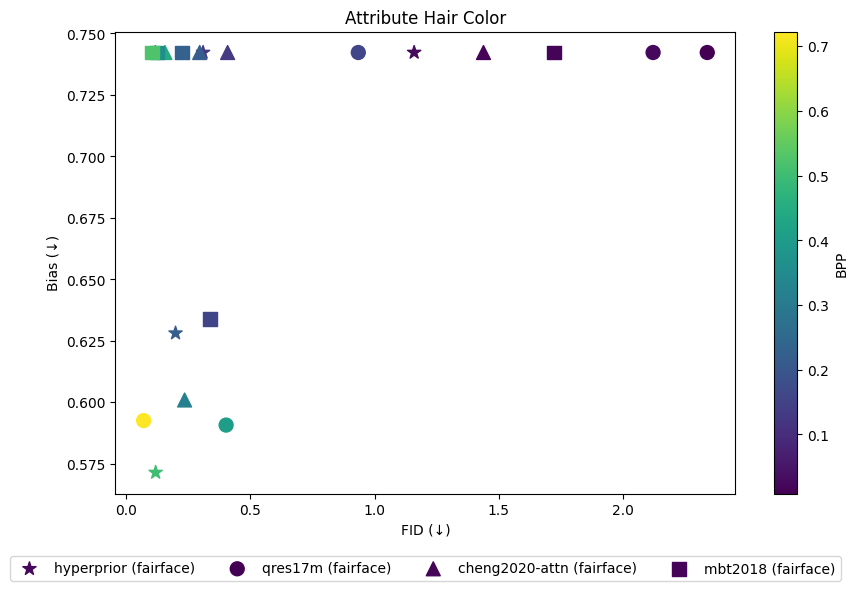

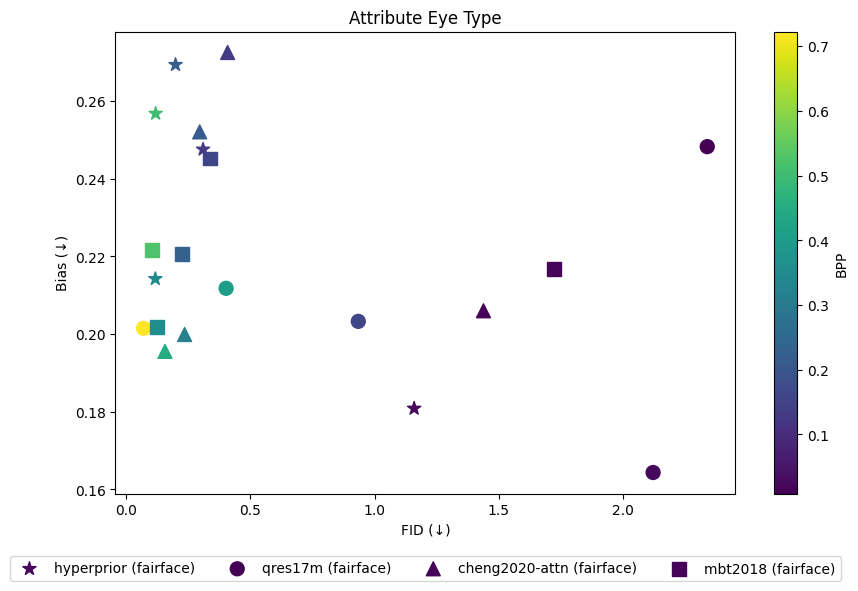

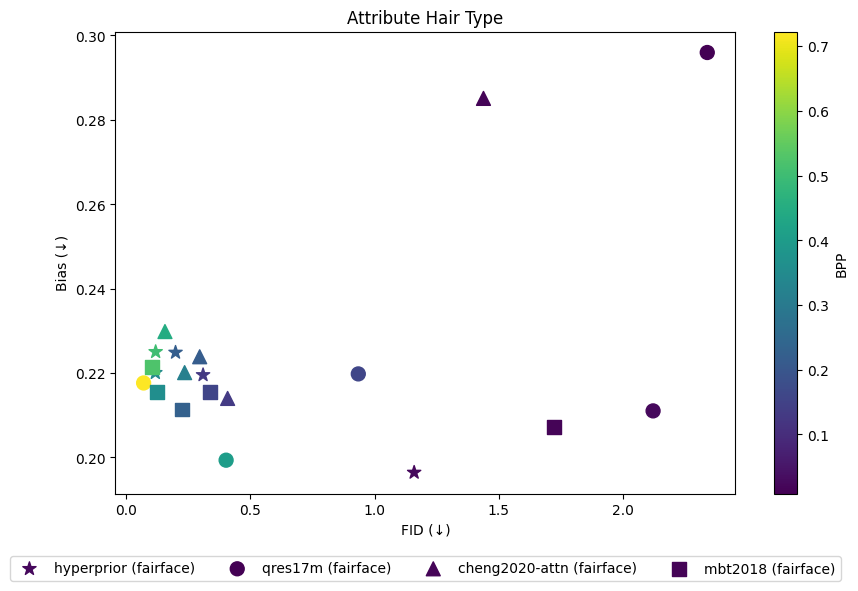

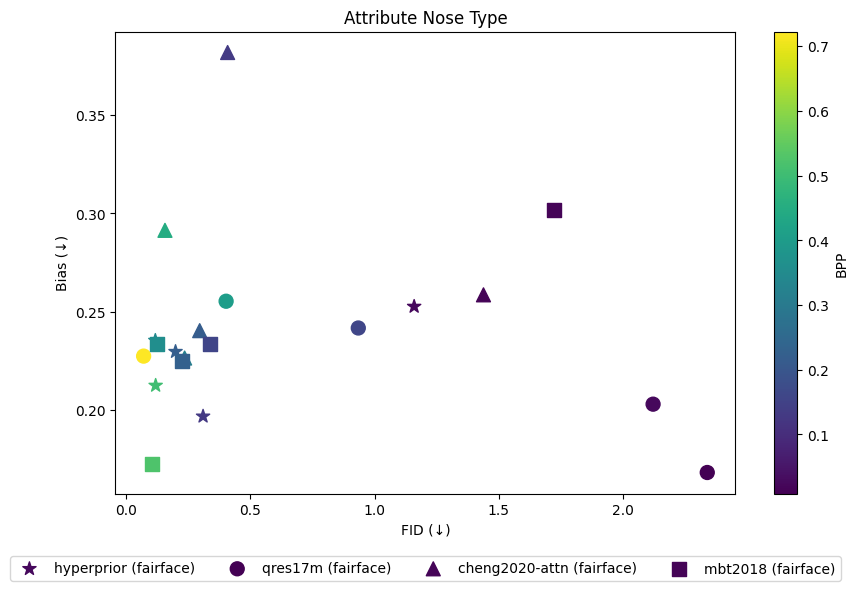

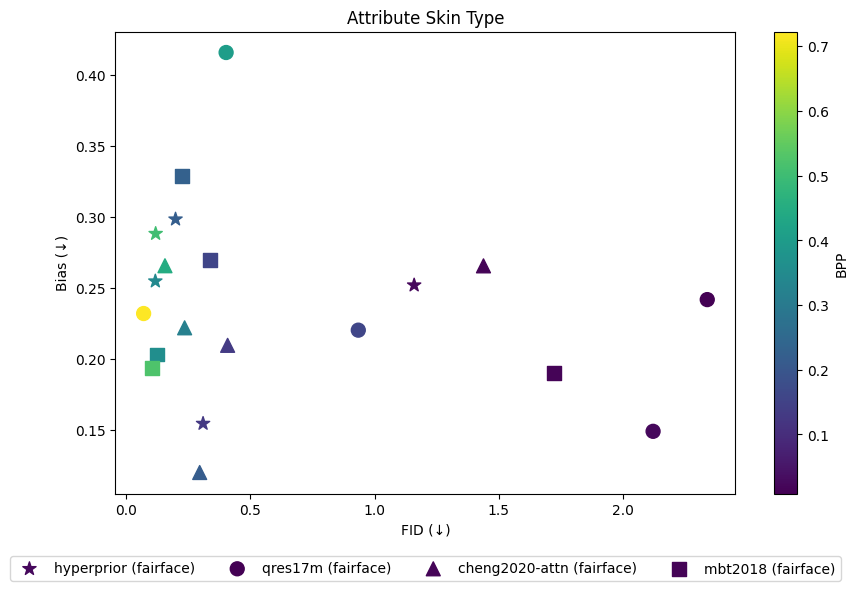

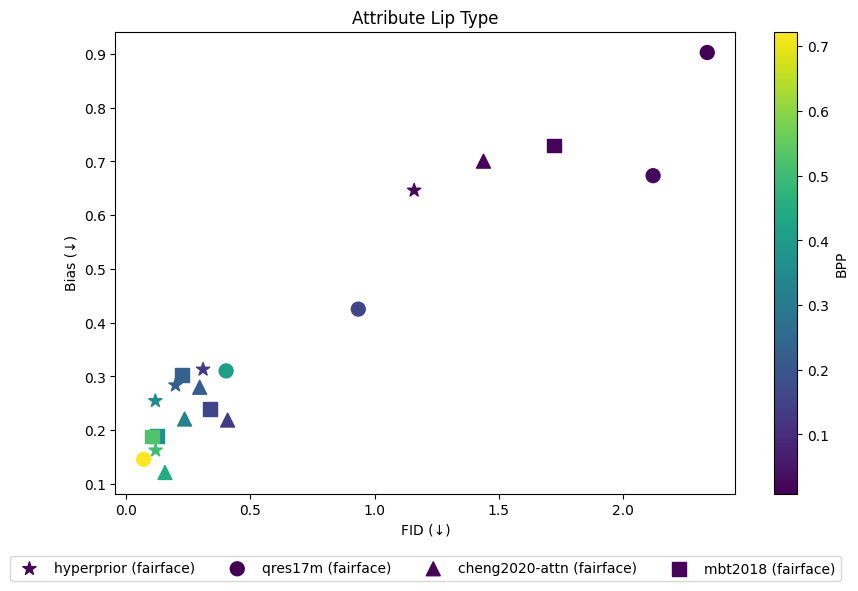

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

model_markers = {
    'qres17m': 'o',
    'mbt2018': 's',
    'hyperprior': '*',
    'cheng2020-attn': '^'
}
# dataset_colors = {
#     'celebA': '#A52A2A',
#     'fairface': '#04D8B2'
# }
cmap = plt.get_cmap('viridis')

# Sample 4 colors from the colormap

# model_colors = {
#     'qres17m': colors[0],
#     'mbt2018': colors[1],
#     'hyperprior': colors[2],
#     'cheng2020-attn': colors[3]
# }

# dataset_makers = {
#     'celebA': '*',
#     'fairface': 's' 
# }

# bpp_scale = 300
attributes = ['hair_color', 'eye_type', 'hair_type', 'nose_type', 'skin_type', 'lip_type']

for attribute in attributes:
    fig, ax = plt.subplots(figsize=(10, 6))
    for model_name in bias_data:
        for dataset_name in ["fairface"]:
            bias = bias_data[model_name][dataset_name][attribute]
            bpps = list(bpp_data[model_name][dataset_name].values())
            norm = mcolors.Normalize(vmin=min(all_bpps_list_fairface), vmax=max(all_bpps_list_fairface))
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            colors = sm.to_rgba(bpps)
            fids = list(fid_data[model_name][dataset_name].values())
            # sizes = np.array(bpps) * bpp_scale
            
            ax.scatter(fids, bias, s=100, c=colors, marker=model_markers[model_name], 
                        label=f'{model_name} ({dataset_name})')
    
    cbar = plt.colorbar(sm, ax=ax, label='BPP')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)

    ax.set_xlabel('FID (\u2193)')
    ax.set_ylabel('Bias (\u2193)')
    ax.set_title(f'Attribute {" ".join(attribute.split("_")).title()}')
            

In [6]:
from ptfid import calculate_metrics_from_folders
results = calculate_metrics_from_folders(
    dataset_dir1=clean_images_path,
    dataset_dir2=generated_images_path,
    feature_extractor='dinov3',
    fid=True,
    resizer='tensorflow',
    normalizer='inception',
    result_file='results.json',
)

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
import numpy as np
from scipy.linalg import sqrtm

DEVICE = 2
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define a function to compute the FID score
def compute_fid(features1, features2):
    # Calculate the mean and covariance of the features
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)
    
    # Calculate the sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    
    # Calculate the sqrt of the product of covariance matrices
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    
    # If imaginary component exists, discard it
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate the FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load the DINO model
model = timm.create_model('vit_small_patch16_224_dino', pretrained=True)
model.to(device)
model.eval()

# Define a transform to match the DINO model's input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets
dataset1 = ImageFolder(root=clean_images_path, transform=transform)
dataset2 = ImageFolder(root=generated_images_path, transform=transform)

loader1 = DataLoader(dataset1, batch_size=32, shuffle=False, num_workers=4)
loader2 = DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=4)

# Function to extract features from a dataset using the DINO model
def extract_features(loader, model, device):
    features = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model.forward_features(images)[:, 0]  # Assuming the model has a method 'forward_features'
            features.append(outputs.cpu().numpy())
    return np.concatenate(features, axis=0)

# Extract features from both datasets
features1 = extract_features(loader1, model, device)
features2 = extract_features(loader2, model, device)

# Compute the FID score
fid_score = compute_fid(features1, features2)
print(f'FID Score: {fid_score}')

Using device: cuda:2
FID Score: 9963.28006742633


In [10]:
import torch
import numpy as np
import timm
from scipy.linalg import sqrtm
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
import numpy as np
from scipy.linalg import sqrtm

# Create the model
model = timm.create_model('vit_small_patch16_224_dino', pretrained=True).to(device)

# Switch to evaluation mode
model.eval()

def get_features(model, loader):
    # with torch.no_grad():
    #     features = model.forward_features(images)
    #     # Exclude the class token, use only patch tokens
    #     patch_tokens = features[:, 1:]
    #     # Flatten the patch tokens
    #     patch_features = patch_tokens.view(patch_tokens.size(0), -1)
    features = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model.forward_features(images)[:, 1:]  # Assuming the model has a method 'forward_features'
            patch_features = outputs.view(outputs.size(0), -1)
            features.append(patch_features.cpu().numpy())
    return np.concatenate(features, axis=0)
    
    
def calculate_fid(features1, features2):
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Example input tensors: batch size of N, 3 color channels, 224x224 image size
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets
dataset1 = ImageFolder(root=clean_images_path, transform=transform)
dataset2 = ImageFolder(root=generated_images_path, transform=transform)

loader1 = DataLoader(dataset1, batch_size=32, shuffle=False, num_workers=4)
loader2 = DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=4)

# Get features for both sets of images
features1 = get_features(model, loader1)
features2 = get_features(model, loader2)
print(f'features1.shape: {features1.shape} - features2.shape: {features2.shape}')
# Calculate FID
fid_score = calculate_fid(features1, features2)
print('FID Score:', fid_score)


features1.shape: (40607, 75264) - features2.shape: (40607, 75264)


In [14]:
features1.shape

(40607, 197, 384)

In [15]:
40607/32

1268.96875

In [13]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [11]:
import torch
from torchvision.models import inception_v3
from torchvision import transforms
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance

device = torch.device(f'cuda:2' if torch.cuda.is_available() else 'cpu')

fid = FrechetInceptionDistance(feature=model).to(device)

In [22]:
update_fid_in_batches(fid, clean_image_tensors, batch_size=64, real=True)
update_fid_in_batches(fid, generated_image_tensors, batch_size=64, real=False)


AssertionError: Input height (64) doesn't match model (224).

In [3]:
from ptfid import calculate_metrics_from_folders

calculate_metrics_from_folders(
    dataset_dir1=clean_images_path,
    dataset_dir2=generated_images_path,
    feature_extractor='dinov2',
    fid=True,

)

Using cache found in /home/rasta/.cache/torch/hub/facebookresearch_dinov2_main


TypeError: tuple expected at most 1 argument, got 2

In [4]:
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import numpy as np
import torch
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

from pytorch_fid.inception import InceptionV3
device = torch.device(f'cuda:2' if torch.cuda.is_available() else 'cpu')


In [31]:
import torch
from torchvision.models import inception_v3
from torchvision import transforms
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
_ = torch.manual_seed(42)
from torchmetrics.image.fid import FrechetInceptionDistance

device = torch.device(f'cuda:3' if torch.cuda.is_available() else 'cpu')

model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14").to(device)
fid = FrechetInceptionDistance(feature=model).to(device)

Using cache found in /home/rasta/.cache/torch/hub/facebookresearch_dinov2_main


In [19]:

resize_transform = transforms.Resize((518, 518))
clean_image_tensors_resized = resize_transform(clean_image_tensors.to('cpu'))

In [20]:
clean_image_tensors_resized.shape

torch.Size([40607, 3, 518, 518])

In [32]:
update_fid_in_batches(fid, clean_image_tensors_resized.float(), batch_size=128, real=True)

In [23]:
clean_image_tensors_resized[:32]

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0